In [66]:
# Front matter
import os
import glob
import re
import pandas as pd
import numpy as np
import scipy.constants as constants
import sympy as sp
from sympy import Matrix, Symbol
from sympy.utilities.lambdify import lambdify
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# Seaborn, useful for graphics
import seaborn as sns

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

rc = {'lines.linewidth': 1, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20,
      'legend.fontsize': 26,
      'xtick.direction': u'in',
      'ytick.direction': u'in'}
sns.set_style('ticks', rc=rc)

In [139]:
# Functions

# Numeric Vinet EOS, used for everything except calculating dP
def VinetEOS(V,V0,K0,Kprime0):
    A = V/V0
    P = 3*K0*A**(-2/3) * (1-A**(1/3)) * np.exp((3/2)*(Kprime0-1)*(1-A**(1/3)))
    return P

# Symbolic Vinet EOS, needed to calculate dP
def VinetEOS_sym(V,V0,K0,Kprime0):
    A = V/V0
    P = 3*K0*A**(-2/3) * (1-A**(1/3)) * sp.exp((3/2)*(Kprime0-1)*(1-A**(1/3)))
    return P

def getEOSparams(EOS_df, phase):
    V0 = np.float(EOS_df[EOS_df['Phase'] == phase]['V0'])
    K0 = np.float(EOS_df[EOS_df['Phase'] == phase]['K0'])
    Kprime0 = np.float(EOS_df[EOS_df['Phase'] == phase]['Kprime0'])
    return V0, K0, Kprime0

# Create a covariance matrix from EOS_df with V0, K0, and K0prime; used to get dP
def getCov3(EOS_df, phase):
    dV0 = np.float(EOS_df[EOS_df['Phase'] == phase]['dV0'])
    dK0 = np.float(EOS_df[EOS_df['Phase'] == phase]['dK0'])
    dKprime0 = np.float(EOS_df[EOS_df['Phase'] == phase]['dKprime0'])
    V0K0_corr = np.float(EOS_df[EOS_df['Phase'] == phase]['V0K0 corr'])
    V0Kprime0_corr = np.float(EOS_df[EOS_df['Phase'] == phase]['V0Kprime0 corr'])
    K0Kprime0_corr = np.float(EOS_df[EOS_df['Phase'] == phase]['K0Kprime0 corr'])
    corr_matrix = np.eye(3)
    corr_matrix[0,1] = V0K0_corr
    corr_matrix[1,0] = V0K0_corr
    corr_matrix[0,2] = V0Kprime0_corr
    corr_matrix[2,0] = V0Kprime0_corr
    corr_matrix[1,2] = K0Kprime0_corr
    corr_matrix[2,1] = K0Kprime0_corr
#     print(corr_matrix)
    sigmas = np.array([[dV0,dK0,dKprime0]])
    cov = (sigmas.T@sigmas)*corr_matrix
    return cov

# Create a covariance matrix with V, V0, K0, and K0prime; used to get dP
def getVinetCov(dV, EOS_df, phase):
    cov3 = getCov3(EOS_df, phase)
    cov = np.eye(4)
    cov[1:4,1:4] = cov3
    cov[0,0] = dV**2
    return cov

def calc_dP_VinetEOS(V, dV, EOS_df, phase):
    # Create function for Jacobian of Vinet EOS
    a,b,c,d = Symbol('a'),Symbol('b'),Symbol('c'),Symbol('d') # Symbolic variables V, V0, K0, K'0
    Vinet_matrix = Matrix([VinetEOS_sym(a,b,c,d)])            # Create a symbolic Vinet EOS matrix
    param_matrix = Matrix([a,b,c,d])                          # Create a matrix of symbolic variables
    # Symbolically take the Jacobian of the Vinet EOS and turn into a column matrix
    J_sym = Vinet_matrix.jacobian(param_matrix).T
    # Create a numpy function for the above expression
    # (easier to work with numerically)
    J_Vinet = lambdify((a,b,c,d), J_sym, 'numpy')
    J = J_Vinet(V,*getEOSparams(EOS_df, phase)) # Calculate Jacobian
#     print(J)
    cov = getVinetCov(dV, EOS_df, phase) # Calculate covariance matrix
#     print(cov)
    dP = (J.T@cov@J).item() # Calculate uncertainty and convert to a scalar
#     print(dP)
    return dP

def plot_results(V_array,P_array,dP_array):
    # Plot results
    fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols=1, sharex=True, figsize=(8, 8), 
                       gridspec_kw = {'height_ratios':[3, 1]})

    h0, = ax0.plot(V_array,P_array,'-',lw=1)
    ax0.fill_between(V_array,P_array+dP_array,P_array-dP_array,alpha=0.3)

    h1, = ax1.plot(V_array,np.zeros(len(P_array)),'-',lw=1)
    ax1.fill_between(V_array,V_array-V_array-dP_array,dP_array,alpha=0.3)

    ax0.set_ylabel(r'Pressure (GPa)', fontsize=18)
    ax1.set_ylabel(r'Pressure Uncertainty (GPa)', fontsize=18)
    ax1.set_xlabel(r'Volume ($\AA^3$)', fontsize=18)

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
    fig.subplots_adjust(hspace=0)
    plt.setp([ax0.get_xticklabels() for a in fig.axes[:1]], visible=False);

In [150]:
# Import EOS information
EOS_df = pd.read_csv('FeAlloyEOS.csv',engine='python')

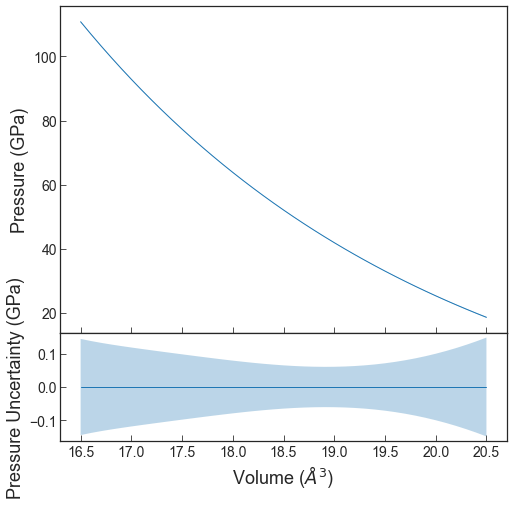

In [151]:
phase = 'hcp Fe'

# Define simple V and dV arrays to check calc_dP_VinetEOS()
V_array = np.linspace(20.5,16.5,41)
dV_array = np.zeros(len(V_array))

# Calculate P and dP
P_array = VinetEOS(V_array,*getEOSparams(EOS_df, phase))
dP_array =[calc_dP_VinetEOS(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]
plot_results(V_array,P_array,dP_array)

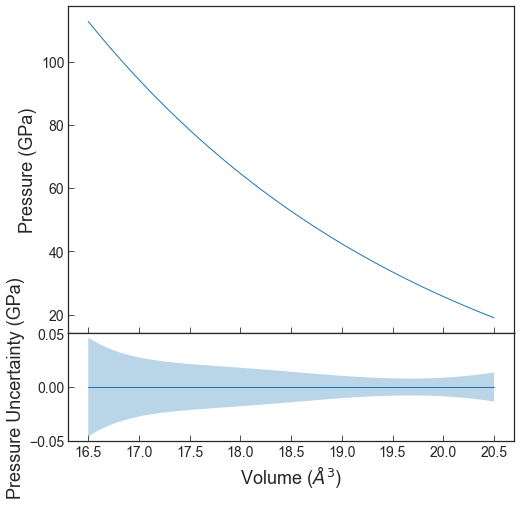

In [152]:
phase = 'hcp FeNi'

# Define simple V and dV arrays to check calc_dP_VinetEOS()
V_array = np.linspace(20.5,16.5,41)
dV_array = np.zeros(len(V_array))

# Calculate P and dP
P_array = VinetEOS(V_array,*getEOSparams(EOS_df, phase))
dP_array =[calc_dP_VinetEOS(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]
plot_results(V_array,P_array,dP_array)

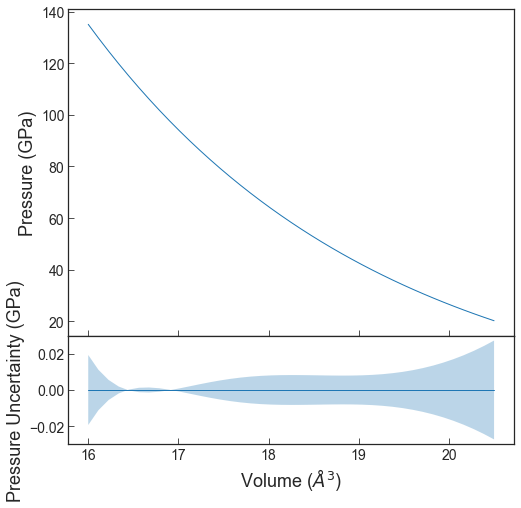

In [153]:
phase = 'hcp FeNiSi'

# Define simple V and dV arrays to check calc_dP_VinetEOS()
V_array = np.linspace(20.5,16.0,41)
dV_array = np.zeros(len(V_array))

# Calculate P and dP
P_array = VinetEOS(V_array,*getEOSparams(EOS_df, phase))
dP_array =[calc_dP_VinetEOS(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]
plot_results(V_array,P_array,dP_array)

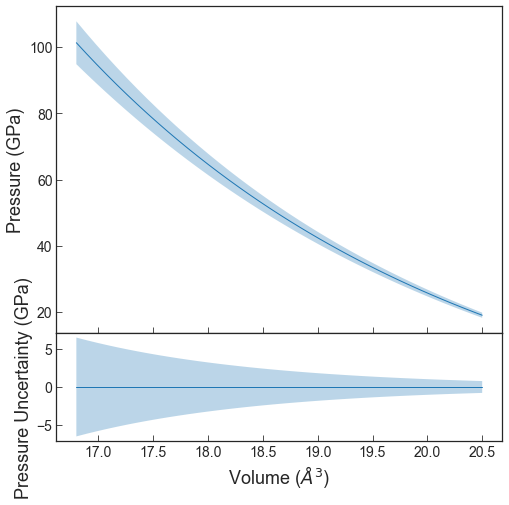

In [165]:
phase = 'hcp FeNi'

# Define simple V and dV arrays to check calc_dP_VinetEOS()
V_array = np.linspace(20.5,16.8,41)
dV_array = 0.07*np.ones(len(V_array))

# Calculate P and dP
P_array = VinetEOS(V_array,*getEOSparams(EOS_df, phase))
dP_array =[calc_dP_VinetEOS(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]
plot_results(V_array,P_array,dP_array)

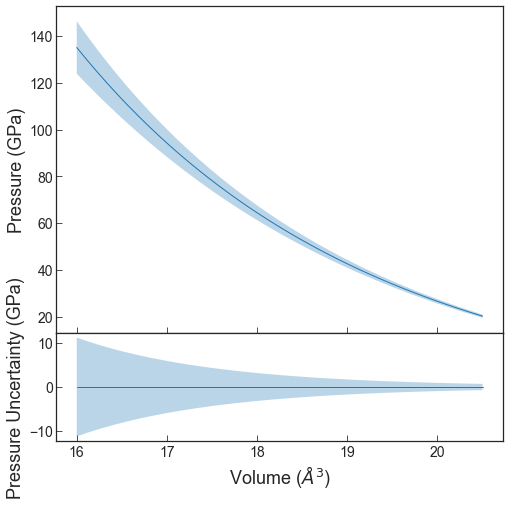

In [160]:
phase = 'hcp FeNiSi'

# Define simple V and dV arrays to check calc_dP_VinetEOS()
V_array = np.linspace(20.5,16.0,41)
dV_array = 0.07*np.ones(len(V_array))

# Calculate P and dP
P_array = VinetEOS(V_array,*getEOSparams(EOS_df, phase))
dP_array =[calc_dP_VinetEOS(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]
plot_results(V_array,P_array,dP_array)

In [118]:
# Covariance agrees with MINUTI
dP = calc_dP_VinetEOS(V,dV,EOS_df, phase)

[[-11.7503395 ]
 [ 10.49503136]
 [  0.16110025]
 [  1.11820322]]
[[ 1.   -0.99  0.96]
 [-0.99  1.   -0.99]
 [ 0.96 -0.99  1.  ]]


In [136]:
# Confirm Jacobian is working

phase = 'hcp FeNiSi'
V = 20.5
V0, K0, Kprime0 = getEOSparams(EOS_df, phase)

# Check Jacobian
dP_dV = (K0/(2*V))*(V/V0)**(-2/3) * np.exp((-3/2)*(Kprime0-1)*((V/V0)**(1/3)-1)) * (3*Kprime0*((V/V0)**(2/3)-(V/V0)**(1/3)) - 3*(V/V0)**(2/3) + 5*(V/V0)**(1/3) - 4)
print(dP_dV)
dP_dV0 = -(K0*V*np.exp((3/2)*(Kprime0 - 1)*(1 - (V/V0)**(1/3)))*(3*Kprime0*(V/V0)**(2/3) - 3*Kprime0*(V/V0)**(1/3) - 3*(V/V0)**(2/3) + 5*(V/V0)**(1/3) - 4))/(2*V0**2*(V/V0)**(5/3))
print(dP_dV0)
dP_dK0 = (V/V0)**(-2/3)*3*(1 - (V/V0)**(1/3))*np.exp((3/2)*(Kprime0 - 1)*(1 - (V/V0)**(1/3)))
print(dP_dK0)
dP_dKprime0 = (1/2)*(V/V0)**(-2/3)*(9*K0*(1 - (V/V0)**(1/3))**2*np.exp((3/2)*(Kprime0-1)*(1-(V/V0)**(1/3))))
print(dP_dKprime0)


A = (V/V0)**(1/3)
B = (V/V0)**(2/3)
C = (V/V0)**(-2/3)
D = (V/V0)**(-5/3)
dP_dV = (K0/(2*V))*C * np.exp((-3/2)*(Kprime0-1)*(A-1)) * (3*Kprime0*(B-A) - 3*B + 5*A - 4)
print(dP_dV)
dP_dV0 = (-K0*V/(2*V0**2))*D * np.exp((3/2)*(Kprime0-1)*(1-A)) * (3*Kprime0*B - 3*Kprime0*A - 3*B + 5*A - 4)
print(dP_dV0)
dP_dK0 = 3*C*(1-A) * np.exp((3/2)*(Kprime0-1)*(1-A))
print(dP_dK0)
dP_dKprime0 = (9*K0/2)*C*(1-A)**2 * np.exp((3/2)*(Kprime0-1)*(1-A))
print(dP_dKprime0)


-11.7503395013
10.4950313601
0.161100248313
1.11820322081
-11.7503395013
10.4950313601
0.161100248313
1.11820322081


In [116]:
phase = 'hcp FeNiSi'

# Define simple V and dV arrays to check calc_dP_VinetEOS()
V_array = np.linspace(23.0,16.5,41)
dV_array = np.zeros(len(V_array))

# Calculate P and dP
P_array = VinetEOS(V_array,*getEOSparams(EOS_df, phase))
# dP_array =[calc_dP_VinetEOS(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]

def calc_dP_VinetEOS_crop(V,dV,EOS_df, phase):
    # Create function for Jacobian of Vinet EOS
    a,b,c,d = Symbol('a'),Symbol('b'),Symbol('c'),Symbol('d') # Symbolic variables V, V0, K0, K'0
    Vinet_matrix = Matrix([VinetEOS_sym(a,b,c,d)])            # Create a symbolic Vinet EOS matrix
    param_matrix = Matrix([a,b,c,d])                          # Create a matrix of symbolic variables
    # Symbolically take the Jacobian of the Vinet EOS and turn into a column matrix
    J_sym = Vinet_matrix.jacobian(param_matrix).T
    # Create a numpy function for the above expression
    # (easier to work with numerically)
    J_Vinet = lambdify((a,b,c,d), J_sym, 'numpy')
    J = J_Vinet(V,*getEOSparams(EOS_df, phase)) # Calculate Jacobian
    J_crop = J[1:4]
    print(J_crop)
    cov = getVinetCov(dV, EOS_df, phase) # Calculate covariance matrix
    print(cov)
    cov_crop = cov[1:4,1:4]
    dP = (J_crop.T@cov_crop@J_crop).item() # Calculate uncertainty and convert to a scalar
    return dP

dP_array =[calc_dP_VinetEOS_crop(V,dV,EOS_df, phase) for V, dV in zip(V_array,dV_array)]
# plot_results(V_array,P_array,dP_array)


[[ 1.   -0.99  0.96]
 [-0.99  1.   -0.99]
 [ 0.96 -0.99  1.  ]]
